Primeros registros de X_train transformados:
    Overall  Potential       Age      Wage
0 -1.764116  -0.861499 -1.305844 -0.403215
1  0.400141   1.410700 -1.092003  0.152792
2 -0.176994  -1.023799  1.046402 -0.264213
3  1.698695   1.735300 -0.236641  1.357473
4  0.832992   1.735300 -0.878163 -0.310547


/Users/MARINHO/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


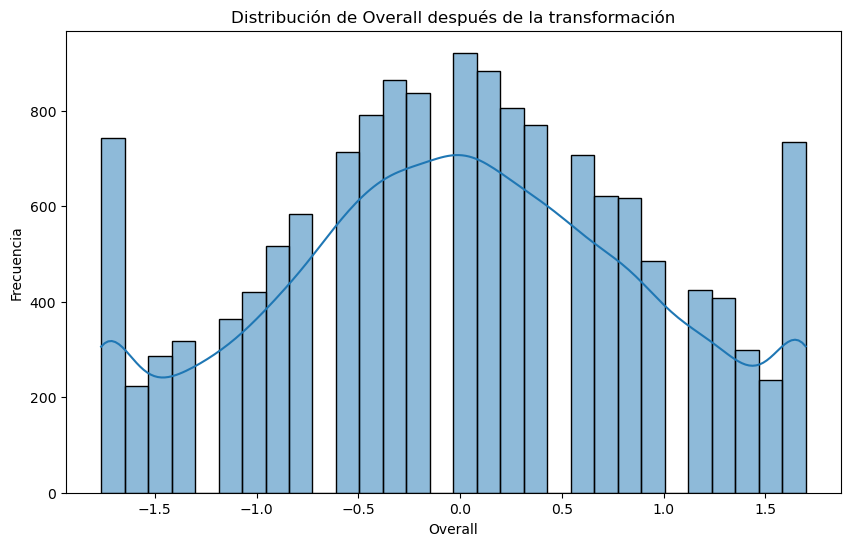

/Users/MARINHO/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


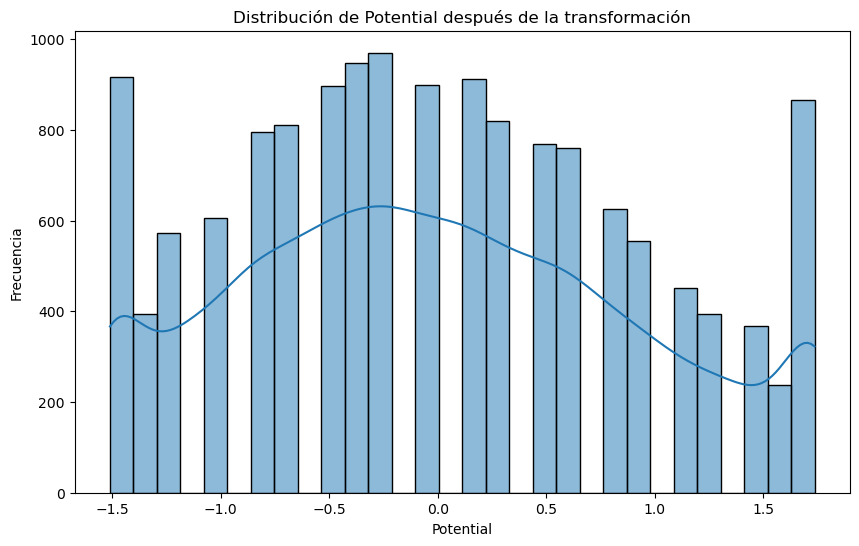

/Users/MARINHO/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


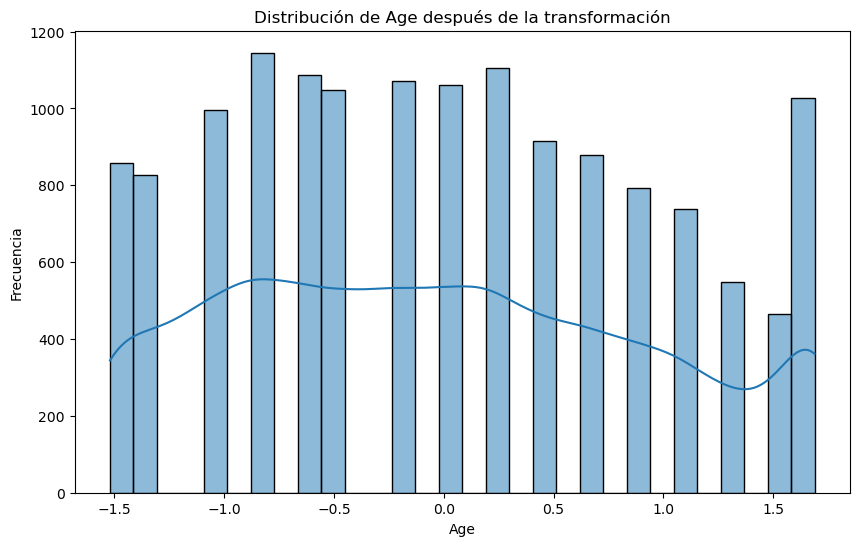

/Users/MARINHO/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


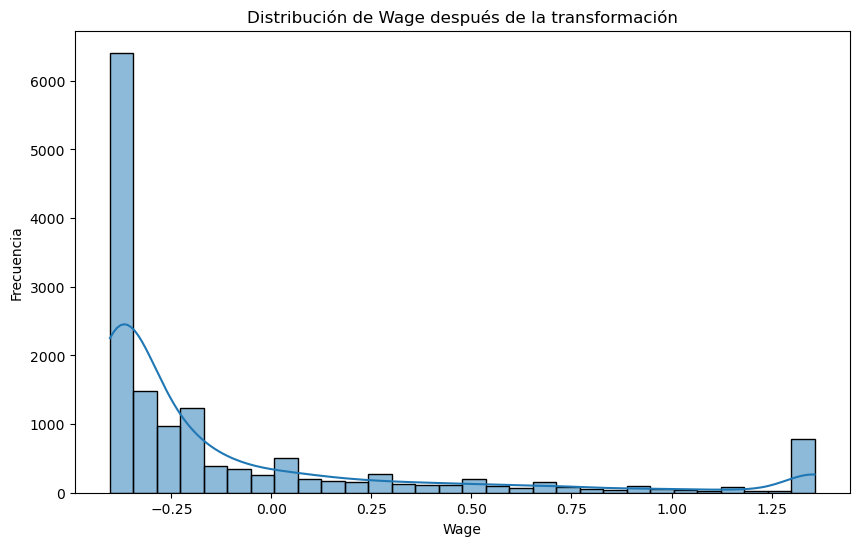

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import mstats

# Cargar los datos
file_path = 'fifa_eda_stats.csv'
dataFoot = pd.read_csv(file_path)

# Selección de Variables
variable_a_predecir = 'Position'  # Reemplazada con la variable categórica a predecir
variables_predictoras = ['Overall', 'Potential', 'Age', 'Wage']  # Consideradas esenciales

# Ingeniería de características
X = dataFoot[variables_predictoras].copy()
y = dataFoot[variable_a_predecir]

# Conversión 'Wage' a valores numéricos (eliminando símbolos y convertiendo a float)
X['Wage'] = X['Wage'].str.replace('€', '').str.replace('K', 'e3').astype(float)

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputación de variables con datos faltantes
# Numérica
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Categórica
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinación de transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Ajustar y transformar los datos
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Obtener nombres de características después de OneHotEncoding
onehot = preprocessor.named_transformers_['cat']['onehot']
onehot.fit(X[categorical_features])
categorical_feature_names = onehot.get_feature_names_out(categorical_features)

# Tratamiento de outliers (usando winsorization)
def winsorize_series(series, limits=[0.05, 0.05]):
    return mstats.winsorize(series, limits=limits)

# Aplicación de winsorization a las variables numéricas en X_train y X_test
# Conversión a DataFrames para la visualización
X_train_df = pd.DataFrame(X_train, columns=numeric_features.tolist() + categorical_feature_names.tolist())
X_test_df = pd.DataFrame(X_test, columns=numeric_features.tolist() + categorical_feature_names.tolist())

for col in numeric_features:
    X_train_df[col] = winsorize_series(X_train_df[col])
    X_test_df[col] = winsorize_series(X_test_df[col])

# primeros registros transformados
print("Primeros registros de X_train transformados:")
print(X_train_df.head())

# Visualización de distribución de las variables después de transformación
for col in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_train_df[col], bins=30, kde=True)
    plt.title(f'Distribución de {col} después de la transformación')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()
